<a href="https://colab.research.google.com/github/TomJiX/ML_start/blob/main/mnist_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Packages

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import random
import cv2
from imgaug import augmenters as iaa
import json
import warnings
import time
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation

In [2]:
! pip install -q kaggle
! pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json



     |████████████████████████████████| 61kB 5.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=5ccf1b72e3197cbd290606dc40b146b3da8937dec5e81ce7a8e6d441c8ff1458
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


Saving kaggle.json to kaggle.json


In [3]:
! kaggle competitions download -c digit-recognizer

 59% 9.00M/15.3M [00:00<00:00, 50.5MB/s]
100% 15.3M/15.3M [00:00<00:00, 79.2MB/s]


In [4]:
%%capture
! unzip digit-recognizer.zip

# Define Constants

In [5]:

NUMBER_OF_CLASSES=10
IMAGE_WIDTH=28
IMAGE_HEIGHT=28
IMAGE_CHANNELS=1
IMAGE_SIZE=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)

TRAIN_DIR="/content/train_dir/"
TEST_DIR="/content/test_dir/"


# Prepare the training and validation data generators

In [6]:
samples_df = pd.read_csv('train.csv')
samples_df.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


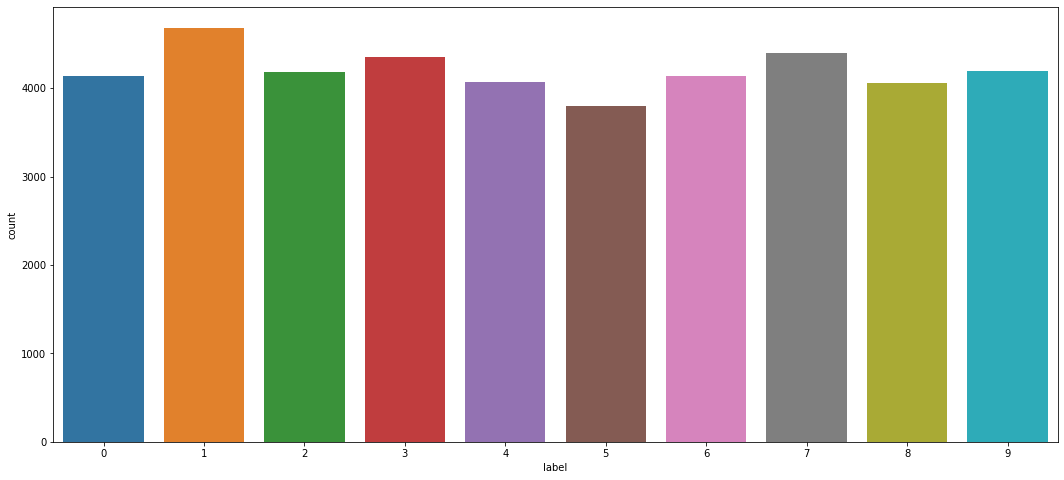

In [7]:
plt.figure(figsize=(18,8))
sns.countplot(samples_df["label"])
plt.show()

I keep 90% of the data provided for training and retain the other 10% for validation during my training process.

In [8]:
train_df, validation_df = train_test_split(samples_df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [9]:
total_train = train_df.shape[0]
total_validate = validation_df.shape[0]

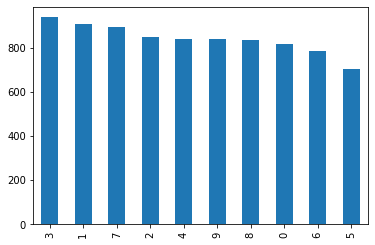

In [10]:
validation_df["label"].value_counts().plot.bar()

I prepare the set of augmentations methods to use on the training data. Beside the traditional image flip and gaussian blur, I have also decided to play with the contrast and scale, as well as grayscale to help the model to focus on textures.

#Making generators


### Validation Generator

In [11]:
batch_size=32

In [12]:
from keras.utils import to_categorical

def extract_train_images(data):
    """
    function to extract list 2d numpy arrays of images and numpy array of labels.
    Input - DataFrame data
    Output - list of 2D numpy arrays for images and 1d numpy array for labels
    
    """
    if 'label' in data:
      labels = np.array(data['label'])
      
      data = data.drop('label', axis = 'columns')
    else:
      labels=[]
    images_array = np.array(data)
    
    images_list = []
    for image_arr in images_array:
        images_list.append(np.array(np.array_split(image_arr, 28))[:,:,np.newaxis])
    
    return images_list, labels

In [13]:
train_images_list, train_labels = extract_train_images(train_df)
train_one_hot_labels = to_categorical(train_labels)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_images = np.array(train_images_list)
train_generator = train_datagen.flow(train_images, train_one_hot_labels, batch_size = batch_size)

In [14]:
val_images_list, val_labels = extract_train_images(validation_df)
val_one_hot_labels = to_categorical(val_labels)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_images = np.array(val_images_list)
val_generator = val_datagen.flow(val_images, val_one_hot_labels, batch_size = batch_size)

# Build the model

I am using an EfficientNetB3 on top of which I add some outputs layers to predict our 5 disease classes. All images are 300x300 pixels as the EfficientNetB3 was initially designed for this type of inputs. I decided to load the imagenet pretrained weights locally to keep the internet off (part of the requirements to submit a kernel to this competition).

In [15]:
FILE_NAME="mnist_basics"

conv_layers = [32,64,128,256]
repeat_conv =6
dropout=0.25

EPOCHS=20

In [20]:
def general_fit():
    start_time=time.time()
    
    for repeat in range(repeat_conv):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SIZE,padding="same"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2),padding="same"))
        model.add(Dropout(dropout))
        name=[]
        for i in range(1,repeat+1):
            random_size=random.choice(conv_layers)
            name.append(random_size)
            model.add(Conv2D(random_size, (3, 3), activation='relu',padding="same"))
            model.add(BatchNormalization())
            model.add(MaxPooling2D(pool_size=(2, 2),padding="same"))
            model.add(Dropout(dropout))  
        NAME=str(repeat)
        for nb in name:
            NAME+="-"+str(nb)
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(10,activation='sigmoid'))

        tensorboard = tf.keras.callbacks.TensorBoard(log_dir="{}-logs/{}".format(FILE_NAME,NAME),histogram_freq=1)

        callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
        EarlyStopping(monitor='val_loss', patience=4),
        tensorboard]

        model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
        model.fit(train_generator,
      steps_per_epoch = int(len(train_df)/batch_size),
      epochs = EPOCHS, 
      validation_data=val_generator,
      validation_steps=int(len(validation_df)/batch_size),
      callbacks=callbacks)
                    
    end_time=time.time()
    print("Processing took %ss"%int(end_time-start_time))
    return


def particular_fit():
    NAME = "4conv32-256-32-256-1-dense"+str(time.time())
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SIZE,padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu',padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), activation='relu',padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu',padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax')) 
 
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=4)]

    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
    model.summary()
    history=model.fit(train_generator,
                  steps_per_epoch = int(len(train_df)/batch_size),
                  epochs = EPOCHS, 
                  validation_data=val_generator,
                  validation_steps=int(len(validation_df)/batch_size),
                  callbacks=callbacks)
    return history,model

Compute the models

In [21]:
# %%capture
# general_fit()

In [22]:
# %load_ext tensorboard
# %tensorboard --logdir /content/mnist_basics-logs/

In [23]:
history,model = particular_fit()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 256)       73984     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 256)        

# Verification of the training process

First, we will check that we perform on similar level on both the training and validation. The training curve will also tell us if we stopped training too early or may have overfitted in comparison to the validation data.

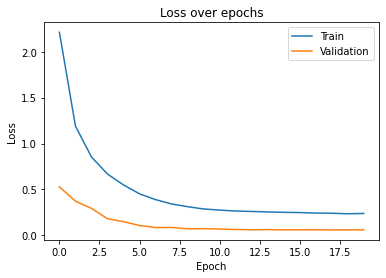

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

We load the best weights that were kept from the training phase. Just to check how our model is performing, we will attempt predictions over the validation set. This can help to highlight any classes that will be consistently miscategorised.

# Prediction on test images

#Predict


In [25]:
def predict_and_vote(data,model):
    images_list, labels = extract_train_images(data)
    if len(labels)==0:
        one_hot_labels = None
    else:
      one_hot_labels = to_categorical(labels)
    datagen = ImageDataGenerator(rescale=1./255)
    images = np.array(images_list)
    generator = val_datagen.flow(images, one_hot_labels, batch_size = 1, shuffle=False)
    
    predictions = model.predict(generator)
    

    return np.argmax(predictions,axis=1),labels

In [26]:
[pred,res]=predict_and_vote(validation_df,model)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(pred, res))
print('Classification Report')
target_names = [str(i) for i in range(10)]
print(classification_report(pred, res, target_names=target_names))

Confusion Matrix
[[813   0   0   1   1   2   0   0   1   5]
 [  0 897   2   0   0   0   0   0   0   1]
 [  0   4 820   2   0  11   6  13   4   0]
 [  0   1   2 928   0   5   0   2   0   4]
 [  0   2   3   0 828   0   1   3   2   1]
 [  0   0  10   3   0 676   0   3   1   0]
 [  2   1   4   0   3   4 777   0   0   0]
 [  0   4   1   1   0   1   0 869   0   5]
 [  1   0   4   1   2   2   1   0 824   4]
 [  0   0   0   1   5   1   0   3   3 818]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       823
           1       0.99      1.00      0.99       900
           2       0.97      0.95      0.96       860
           3       0.99      0.99      0.99       942
           4       0.99      0.99      0.99       840
           5       0.96      0.98      0.97       693
           6       0.99      0.98      0.99       791
           7       0.97      0.99      0.98       881
           8       0.99      0.98      0.98

#Submission


In [28]:
submission_df = pd.read_csv('test.csv')

[pred,res]=predict_and_vote(submission_df,model)

In [29]:
submission=pd.DataFrame({"ImageId":[i for i in range(1,submission_df.shape[0]+1)],"label":pred})
submission.head()

,ImageId,label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [30]:
submission.to_csv("submission.csv",index=None)